In [5]:
from math import sin, cos, pi
from matplotlib import pyplot as plt
import numpy as np

d_to_r = pi/180
LINE = 6 
ANGLE = [0, 9,18,27,36, 45]
SYMMETRY = [(-1, 1), (-1, -1), (1, -1)]

def polar_to_xy(polar):
    coor = []
    for i in range(LINE):
        x = cos(ANGLE[i] * d_to_r) * polar[i]
        y = sin(ANGLE[i] * d_to_r) * polar[i]
        coor.append([x, y])
    for i in range(LINE-1, -1, -1):
        coor.append([coor[i][1], coor[i][0]])
    quarter = 1
    for dx, dy in SYMMETRY:
        if quarter%2 == 1:
            for i in range(LINE*2 - 1, -1, -1):
                coor.append([coor[i][0]*dx, coor[i][1]*dy])
        else:
            for i in range(LINE*2):
                coor.append([coor[i][0]*dx, coor[i][1]*dy])
        quarter += 1 
    return coor

def spectrum_generator(shape):
    vertices = [mp.Vector3(shape[0][0], shape[0][1])] 
    for i in range(1, len(shape) - 1):
        # eliminate duplicate point
        if abs(shape[i][0] - shape[i-1][0]) < 1e-5 and abs(shape[i][1] - shape[i-1][1]) < 1e-5:
            continue
        vertices.append(mp.Vector3(shape[i][0], shape[i][1]))
        print(shape[i])
    # calculate transmission
    return get_trans(vertices)
    

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import math
import meep as mp
import cmath

shape_size = 48

sx, sy, sz = 1, 1, 4
h = 1.25
dpml = 0.5
b_m, c_m = 1.4, 3.54
res = 15
echo = 1000
cell_size = mp.Vector3(sx,sy,sz)
fcen = 0.5
df = 0.2
theta = math.radians(0)
nfreq = 200

# k with correct length (plane of incidence: XZ) 
k = mp.Vector3(math.sin(theta),0,math.cos(theta)).scale(fcen)
def pw_amp(k, x0):
    def _pw_amp(x):
        return cmath.exp(1j * 2 * math.pi * k.dot(x + x0))
    return _pw_amp

def get_trans(vertices):
    geometry = [mp.Block(size = cell_size, material=mp.Medium(index=b_m)),
                mp.Prism(vertices, 
                         height=h, 
                         material=mp.Medium(index=c_m),
                         center=mp.Vector3()
                        )]
    pml_layers = [mp.PML(thickness=1, direction = mp.Z, side=mp.High),
                  mp.Absorber(thickness=1,direction = mp.Z, side=mp.Low)]
    src_pos = -(sz/2 - dpml - 0.5)
    src = [mp.Source(src = mp.GaussianSource(fcen, fwidth=df),
                     component = mp.Ey,
                     center = mp.Vector3(0,0,src_pos),
                     size = mp.Vector3(sx,sy,0),
                     amp_func=pw_amp(k,mp.Vector3(0,0,src_pos)))]
    sim = mp.Simulation(resolution=res,
                        cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=src,
                        geometry=geometry,
                        k_point=k)
    freg = mp.FluxRegion(center=mp.Vector3(0,0,-src_pos),
                         size = mp.Vector3(sx,sy,0))
    trans = sim.add_flux(fcen, df, nfreq, freg)
    sim.run(until = echo)
    bend = mp.get_fluxes(trans)
    
    
    straight = np.genfromtxt('data/straight.txt')
    sim.reset_meep()
    Ts = []
    for i in range(nfreq):
        Ts = np.append(Ts, bend[i]/straight[i])
    return Ts


In [17]:
T_shape = [0.19753767, 0.2,        0.2,        0.14600443, 0.11723925, 0.1        ]
P_shape = [0.16876617, 0.17391512, 0.1800358,  0.16784903, 0.16594785, 0.16888513]

In [18]:
Ts = spectrum_generator(polar_to_xy(P_shape))

[0.17177393627720428, 0.027206318759607558]
[0.171224220756411, 0.055634121795889155]
[0.1495545808086891, 0.07620186501049818]
[0.13425463082998462, 0.09754169887964349]
[0.11941982066457164, 0.11941982066457162]
[0.09754169887964349, 0.13425463082998462]
[0.07620186501049818, 0.1495545808086891]
[0.055634121795889155, 0.171224220756411]
[0.027206318759607558, 0.17177393627720428]
[0.0, 0.16876617]
[-0.027206318759607558, 0.17177393627720428]
[-0.055634121795889155, 0.171224220756411]
[-0.07620186501049818, 0.1495545808086891]
[-0.09754169887964349, 0.13425463082998462]
[-0.11941982066457162, 0.11941982066457164]
[-0.13425463082998462, 0.09754169887964349]
[-0.1495545808086891, 0.07620186501049818]
[-0.171224220756411, 0.055634121795889155]
[-0.17177393627720428, 0.027206318759607558]
[-0.16876617, 0.0]
[-0.17177393627720428, -0.027206318759607558]
[-0.171224220756411, -0.055634121795889155]
[-0.1495545808086891, -0.07620186501049818]
[-0.13425463082998462, -0.09754169887964349]
[-0.1

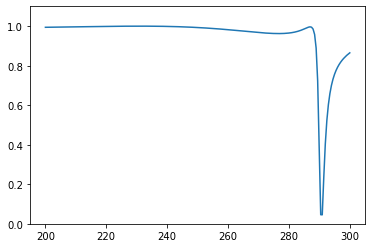

In [19]:
freq = np.genfromtxt('data/freq.txt')
plt.ylim(0, 1.1)
plt.plot(freq, Ts)
plt.show()

T_shape = [0.19753767, 0.2,        0.2,        0.14600443, 0.11723925, 0.1        ]<br>
P_shape = [0.16876617, 0.17391512, 0.1800358,  0.16784903, 0.16594785, 0.16888513]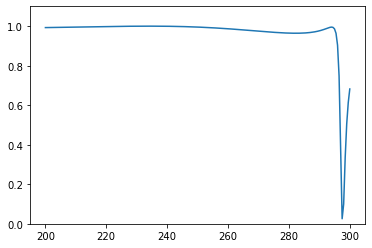

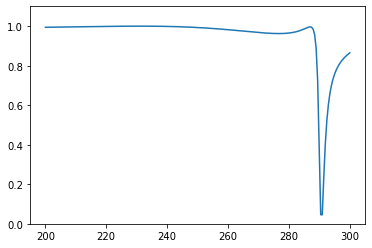

T_shape = [0.1902113,  0.19258231, 0.2,        0.19753767, 0.2,        0.19753767        ]<br>
P_shape = [0.18516362, 0.1887896,  0.1970211,  0.1915434,  0.19702457, 0.18817553]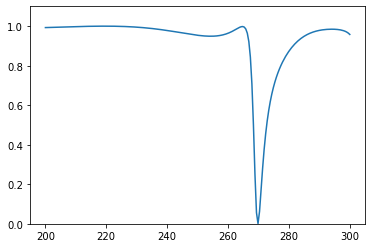

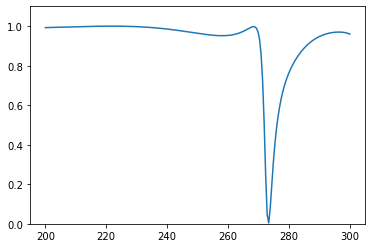

T_shape = [0.09876883, 0.1,        0.2,        0.3,        0.2,        0.2        ]<br>
P_shape = [0.21186525, 0.21368363, 0.20864281, 0.17935243, 0.14165486, 0.12796003]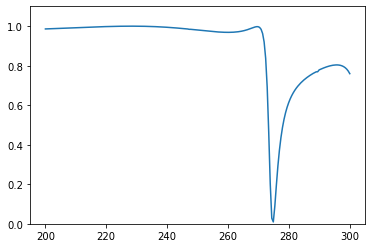

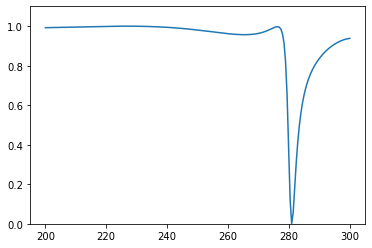

T_shape = [0.2,        0.19507534, 0.19507534, 0.2,        0.2,        0.19753767        ]<br>
P_shape = [0.18889648, 0.19220817, 0.20235068, 0.19841123, 0.19872138, 0.1904945]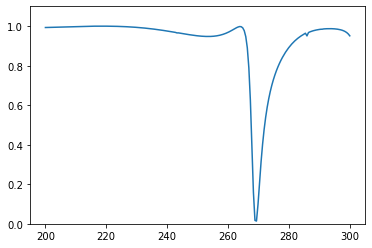

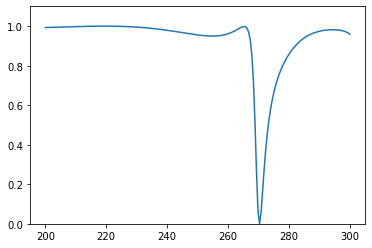